# Import Libraries

In [410]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa import stattools, ar_model
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Activation
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

# Load & Plot Data

In [412]:
df = pd.read_csv("chiba_Temperature.csv")

In [413]:
dict1 = {"Jan":"01", "Feb":"02", "Mar":"03", "Apr":"04", "May":"05", "Jun":"06",
         "Jul":"07", "Aug":"08", "Sep":"09", "Oct":"10", "Nov":"11", "Dec":"12"}

In [414]:
year_ = df["Date"].str.split("-").apply(lambda x : 1900+int(x[1]) if int(x[1])>= 66 else 2000+int(x[1]))
month_ = df["Date"].str.split("-").apply(lambda x : x[0]).map(dict1)
df["Date"] = [datetime(year_[i], int(month_[i]), 1) for i in range(len(df))]

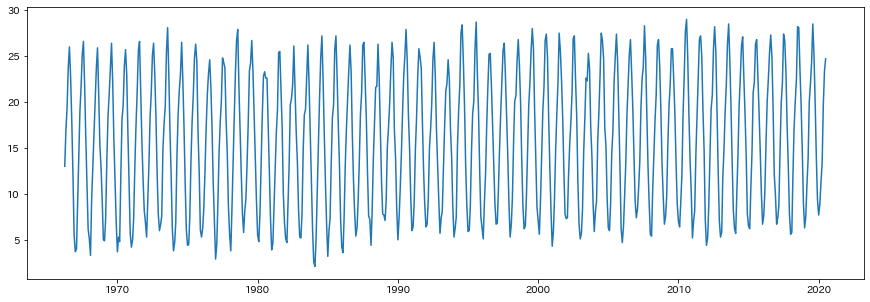

In [416]:
plt.figure(figsize=(15, 5))
plt.plot(df.Date, df.Temperature)
plt.show()

# Chech acf & pacf

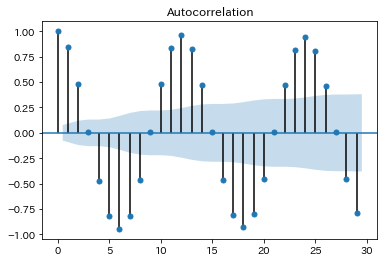

In [417]:
sm.graphics.tsa.plot_acf(df.Temperature)
plt.show()

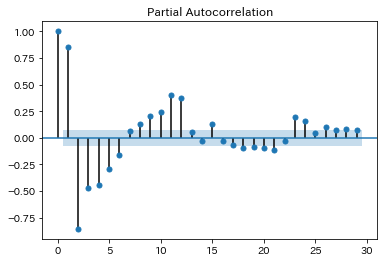

In [418]:
sm.graphics.tsa.plot_pacf(df.Temperature)
plt.show()

# Season Analysis

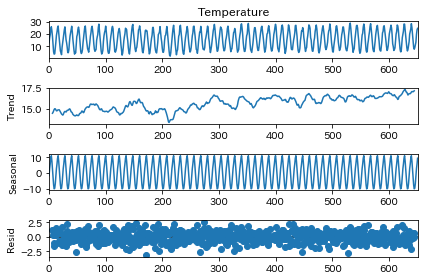

In [728]:
season = sm.tsa.seasonal_decompose(df.Temperature, period=12)
season.plot()
plt.show()

# Split Data

In [419]:
train = df.Temperature.iloc[0:int(len(df)*0.8)]
test = df.Temperature.iloc[int(len(df)*0.8):]

# Check the Stationarity(Augmented Dickey-Fulluer Test)

In [420]:
ctt=stattools.adfuller(train, regression="ctt")#With Trend(2 degree), Const
ct=stattools.adfuller(train, regression="ct")#With Trend(1 degree), Const
c=stattools.adfuller(train, regression="c")#With Const
nc=stattools.adfuller(train, regression="nc")

print(ctt)
print(ct)
print(c)
print(nc)

(-5.615830804296648, 7.59746049401299e-05, 18, 502, {'1%': -4.394358840940107, '5%': -3.844204840341812, '10%': -3.560571545894326}, 1616.7100991917755)
(-5.591824441723766, 1.5132824133237586e-05, 18, 502, {'1%': -3.9769179319416987, '5%': -3.419272031977485, '10%': -3.1322163496677566}, 1615.0647312003082)
(-3.380201160205259, 0.011652616582304792, 17, 503, {'1%': -3.4434175660489905, '5%': -2.8673031724657454, '10%': -2.5698395516760275}, 1630.4831383181065)
(0.13813909878165614, 0.7283035782467759, 17, 503, {'1%': -2.5701992658759174, '5%': -1.9415470506046875, '10%': -1.6163024957790144}, 1640.7352778972036)


# Time Series Analysis

In [435]:
def plot_resid(resid):
    plt.bar(range(len(resid)), resid)
    plt.title("Residual")
    plt.show()
    sm.graphics.tsa.plot_pacf(resid)
    plt.show()
    return np.mean(np.abs(resid))

In [438]:
def plot_prediction(result):
    plt.figure(figsize=(15, 5))
    plt.plot(df.Temperature, label="")
    plt.plot(np.hstack([train[:48], 
             result.fittedvalues, 
             result.predict(len(train[:lags_[np.argmin(aic_)]])+len(result.fittedvalues), len(df))]), linestyle="--")
    plt.show()

In [470]:
def plot_prediction2(result):
    plt.figure(figsize=(15, 5))
    plt.plot(df.Temperature, label="")
    plt.plot(np.hstack([result.fittedvalues, 
             result.predict(len(result.fittedvalues), len(df))]), linestyle="--")
    plt.show()

## AR

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


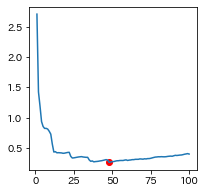

In [458]:
lags_ = []
aic_ = []
for i in range(100):
    model = ar_model.AR(train)
    results = model.fit(maxlag=i+1)
    lags_.append(i+1)
    aic_.append(results.aic)

plt.figure(figsize=(3, 3))
plt.plot(lags_, aic_)
plt.scatter(lags_[np.argmin(aic_)], aic_[np.argmin(aic_)], c = "red")
plt.show()

In [459]:
model = ar_model.AR(train)
result_AR = model.fit(maxlag=lags_[np.argmin(aic_)])
res_AR = results48.resid

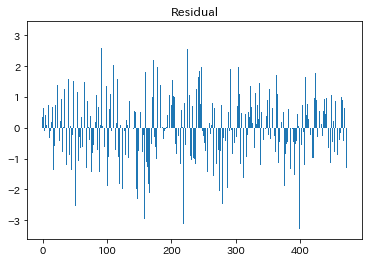

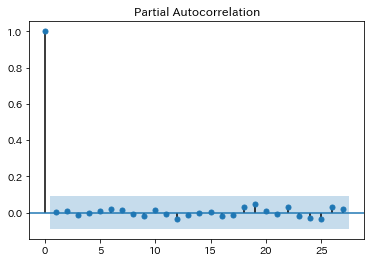

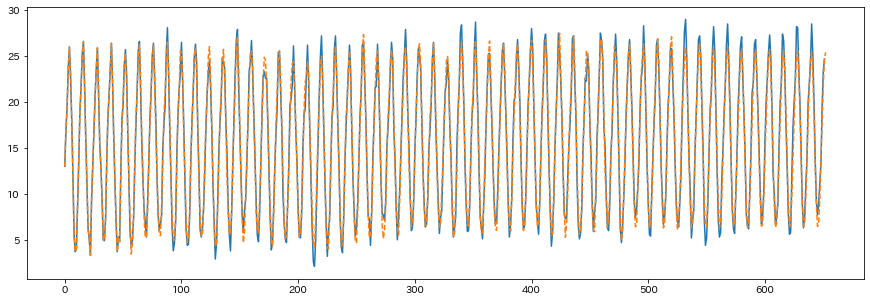

In [460]:
mae_AR = plot_resid(res_AR)
plot_prediction(result_AR)

## ARMA

In [461]:
info_criteria = stattools.arma_order_select_ic(train, ic=["aic", "bic"])
print("aic_order:", info_criteria.aic_min_order)
print("bic_order:", info_criteria.bic_min_order)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\bas

aic_order: (4, 2)
bic_order: (4, 2)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [466]:
model = ARMA(train, info_criteria.aic_min_order)
result_ARMA = model.fit()
res_ARMA = result_ARMA.resid

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


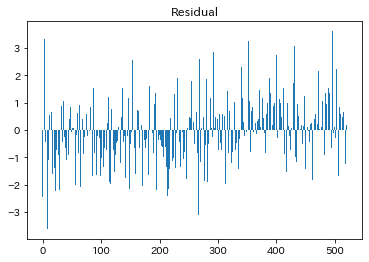

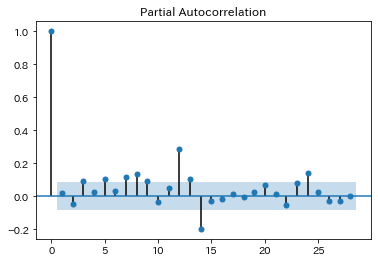

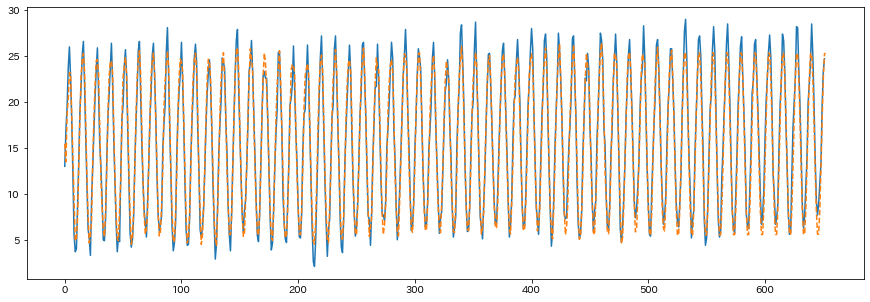

In [471]:
mae_ARMA = plot_resid(res_ARMA)
plot_prediction2(result_ARMA)

## ARIMA

In [472]:
aic_ = []
for p in range(5):
    for d in range(2):
        for q in range(5):
            model = ARIMA(train, order=(p, d, q))
            try:
                result = model.fit()
                aic_.append([(p, d, q), result.aic])
            except ValueError:
                pass
            except np.linalg.LinAlgError:
                pass
opt_oder = aic_[np.argmin(np.array(aic_)[: , 1])][0]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\bas

In [473]:
model = ARIMA(train, opt_oder)
result_ARIMA = model.fit()
res_ARIMA = result.resid

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


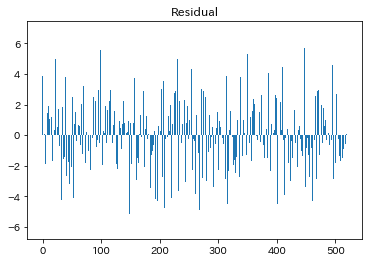

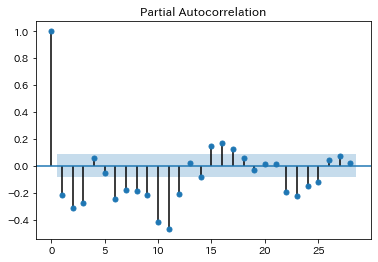

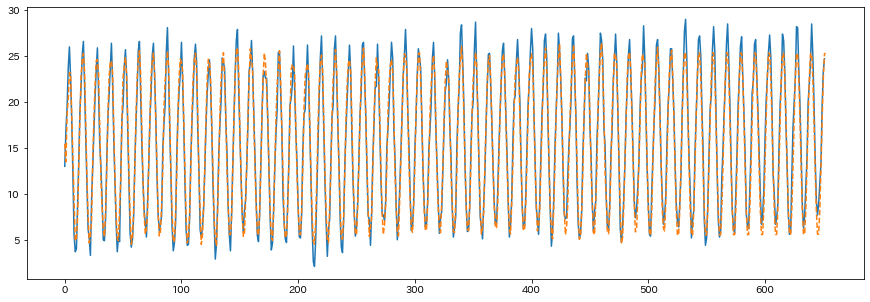

In [474]:
mae_ARIMA = plot_resid(res_ARIMA)
plot_prediction2(result_ARIMA)

## SARIMAX

In [475]:
aic_ = []
seasonal = 12
for p in range(3):
    for d in range(2):
        for q in range(3):
            for sp in range(2):
                for sd in range(2):
                    for sq in range(2):
                        model = SARIMAX(train, order=(p, d, q), 
                                        seasonal_order=(sp, sd, sq, seasonal), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
                        try:
                            result = model.fit()
                            aic_.append([(p, d, q, sp, sd, sq), result.aic])
                        except ValueError:
                            pass
                        except np.linalg.LinAlgError:
                            pass
    opt_oder = aic_[np.argmin(np.array(aic_)[: , 1])][0]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\ProgramData\Anaconda3\lib\site-packages\st

In [476]:
model = SARIMAX(train, order=opt_oder[0:3], 
                seasonal_order=tuple(list(opt_oder[3:]) + [seasonal]), 
                enforce_stationarity=False, 
                enforce_invertibility=False)
result_SARIMAX = model.fit()
res_SARIMAX = result.resid

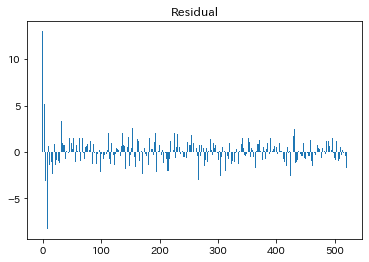

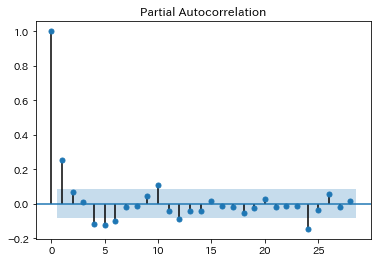

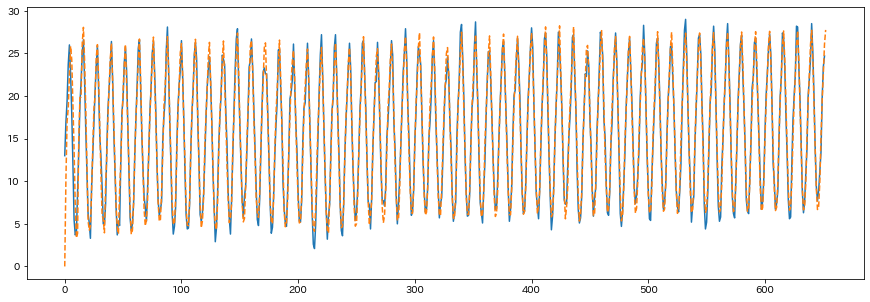

In [477]:
mae_SARIMAX = plot_resid(res_SARIMAX)
plot_prediction2(result_SARIMAX)

## LSTM

In [619]:
def create_dataset(X, y, time_steps=1):

    Xs,ys = [], []
    time_steps = time_steps
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [643]:
sc = StandardScaler()
train_std = sc.fit_transform(train.values.reshape(-1, 1))
test_std = sc.transform(test.values.reshape(-1, 1))
train_std = pd.Series(train_std.ravel(), name=train.name)
test_std = pd.Series(test_std.ravel(), name=test.name)

In [684]:
X_train, y_train = create_dataset(train_std, train_std, time_steps=2)
X_test, y_test = create_dataset(test_std, test_std, time_steps=2)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [685]:
timesteps =  X_train.shape[1]
num_features =  X_train.shape[2]

In [709]:
model = Sequential([
    #Dense(32, input_shape=(timesteps, num_features)),
    LSTM(128, input_shape=(timesteps, num_features)),
    Dense(1,  activation="linear"  )
])
model.summary()

model.compile(loss='mae', optimizer='adam')

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [710]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/100
4/4 [==============================] - 0s 83ms/step - loss: 0.9048 - val_loss: 0.8894
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.8738 - val_loss: 0.8615
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8437 - val_loss: 0.8339
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.8162 - val_loss: 0.8057
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7937 - val_loss: 0.7787
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7745 - val_loss: 0.7543
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7595 - val_loss: 0.7371
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 0.7487 - val_loss: 0.7270
Epoch 9/100
4/4 [==============================] - 0s 10ms/step - loss: 0.7388 - val_loss: 0.7191
Epoch 10/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7300 - val_loss: 0.7112
Epoch 11/100
4/4 [==

In [711]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 1ms/step - loss: 0.2175


0.2175390124320984

In [712]:
def plotting_history(history):
    plt.figure(figsize=(4, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

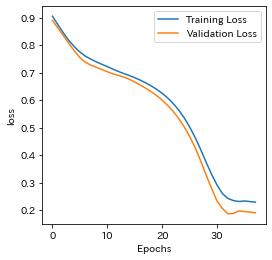

In [713]:
plotting_history(history)

In [714]:
X, y = create_dataset(pd.Series(sc.transform(df.Temperature.values.reshape(-1 ,1)).ravel()), 
              pd.Series(sc.transform(df.Temperature.values.reshape(-1 ,1)).ravel()), time_steps=2)

X = X.reshape(X.shape[0], X.shape[1], 1)

In [715]:
resid_LSTM = sc.inverse_transform(model.predict(X_train)).ravel() - sc.inverse_transform(y_train).ravel()
mae_LSTM = np.mean(np.abs(resid_LSTM))

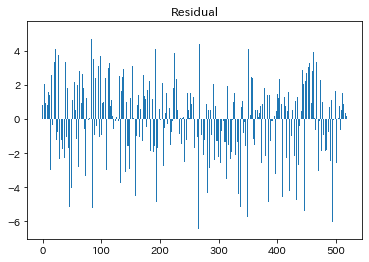

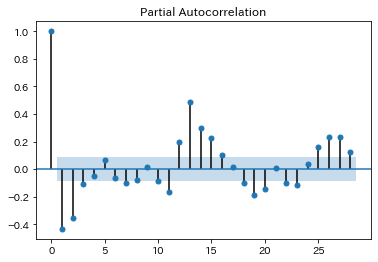

1.6293807246551806

In [716]:
plot_resid(resid_LSTM)

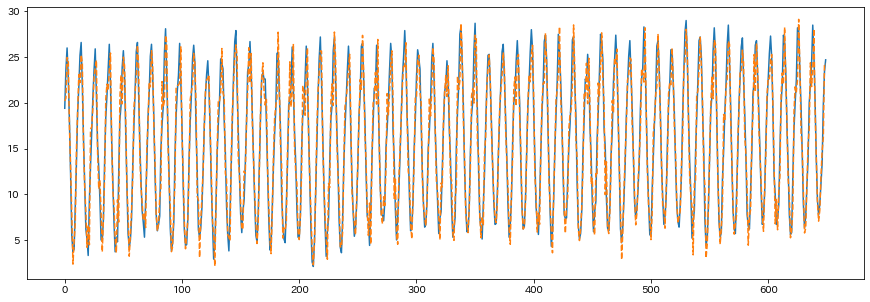

In [720]:
plt.figure(figsize=(15, 5))
plt.plot(sc.inverse_transform(y).ravel())
plt.plot(sc.inverse_transform(model.predict(X)).ravel(), linestyle="--")
plt.show()

# Comparison

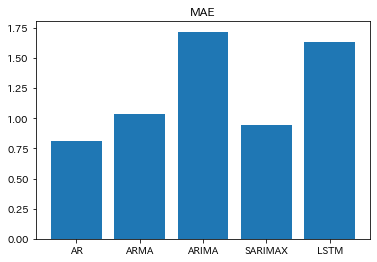

In [719]:
plt.title("MAE")
plt.bar(["AR", "ARMA", "ARIMA", "SARIMAX", "LSTM"], [mae_AR, mae_ARMA, mae_ARIMA, mae_SARIMAX, mae_LSTM])
plt.show()